---
# Environnement
---

In [ ]:
!pip install -U yellowbrick

     |████████████████████████████████| 274 kB 5.1 MB/s 


In [ ]:
from google.colab import files
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import plotly.express as px
import matplotlib.cm as cm
import string
import pandas as pd
import nltk
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!pip3 install seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# uploaded = files.upload()

In [ ]:
 original_data = pd.read_csv('/content/gdrive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv', sep=',')
#original_data = pd.read_csv('/content/gdrive/MyDrive/OpenClassrooms/P6/flipkart_com-ecommerce_sample_1050.csv', sep=',')


---
# Exploration
---

### Qu'est-ce qu'on a là dedans?

In [ ]:
original_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Describe

In [ ]:
original_data.describe()

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


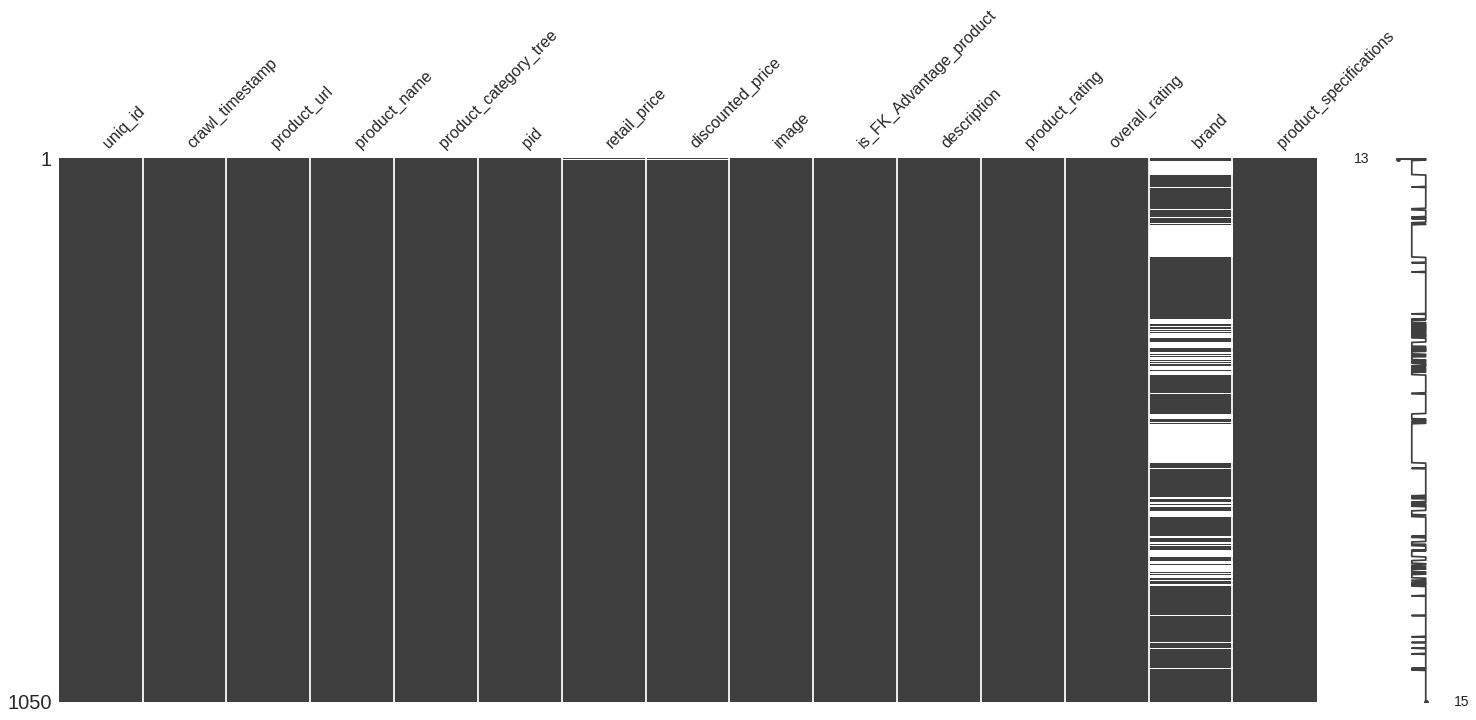

In [ ]:
msno.matrix(original_data)

La table est plutôt bien remplie, la modification sera nécessaire mais légère.



---
# Cleaning
---

On crée data pour stocker et manipuler sans détériorer la data originale

In [ ]:
data = original_data

Nous allons tout de même devoir au moins clean la variable produit afin

1.   Élément de liste
2.   Élément de liste

d'observer l'évolution de la donnée

In [ ]:
def clean_it(x):
  t = x.index('"')
  p = x.index('>')
  x = x[t+1:p-1]
  return(x)

data.loc[:,"product_category_tree"] = data.loc[:,"product_category_tree"].apply(lambda x: clean_it(x))
data.loc[0:3,"product_category_tree"]

0    Home Furnishing
1          Baby Care
2          Baby Care
3    Home Furnishing
Name: product_category_tree, dtype: object

La transformation a fonctionné on a les catégories

<BarContainer object of 7 artists>

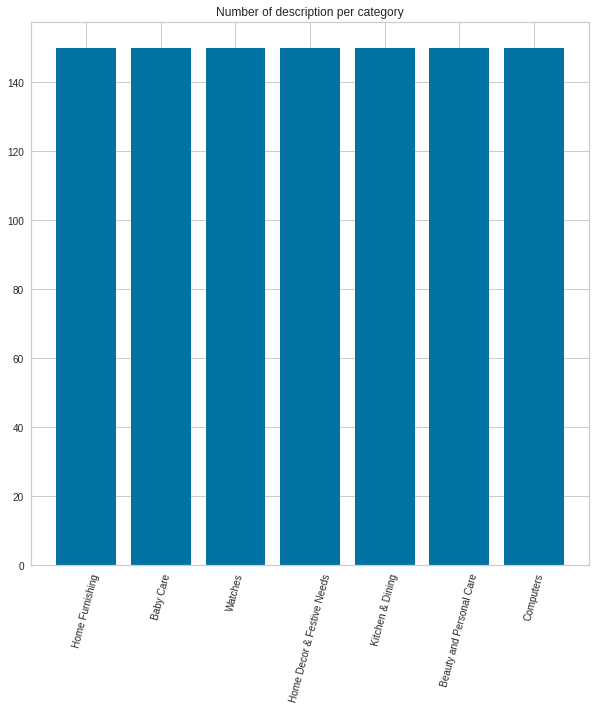

In [ ]:
temp = data.loc[:,"product_category_tree"].value_counts()

plt.figure(figsize=(10,10))
plt.title(label="Number of description per category")
plt.xticks(rotation='75')
plt.bar(temp.index, temp)

Les produits sont équitablement répartis

---
# Traitement de texte et observations
---

Maintenant que cela est fait, on passe à la manipulation des mots de la description et leur observation.

---
## 1ères Observations et cleaning
---

In [ ]:
for i in range(0, 5):
  print(str(i)+": "+data.loc[i,'description'])

0: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that y

Voilà à quoi ressemble les descriptions à la base

In [ ]:
data.loc[0:5,['product_category_tree','description']]

,product_category_tree,description
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...
5,Watches,Maserati Time R8851116001 Analog Watch - For ...


---
### Nombre de mots par category
---

In [ ]:
data['nWord'] = data.loc[:,'description'].apply(lambda x: len(x.split()))
data['nWord']

0       230
1        74
2       215
3       145
4       214
       ... 
1045    419
1046    287
1047     37
1048     31
1049     29
Name: nWord, Length: 1050, dtype: int64

<BarContainer object of 7 artists>

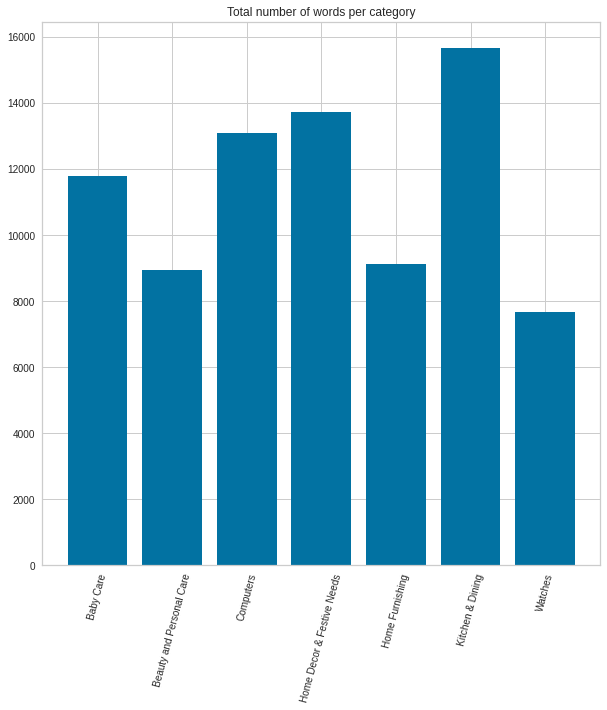

In [ ]:
k = data.loc[:,['product_category_tree','nWord']].groupby(by=['product_category_tree']).sum()
k = k.reset_index()
plt.figure(figsize=(10,10))
plt.title(label="Total number of words per category")
plt.xticks(rotation='75')
plt.bar(k['product_category_tree'], k['nWord'])

Beauty, home furnishing et watches contiennnent moins de mots.
La ou computers, home decor et kitchen sont plus fournis au total.

<BarContainer object of 7 artists>

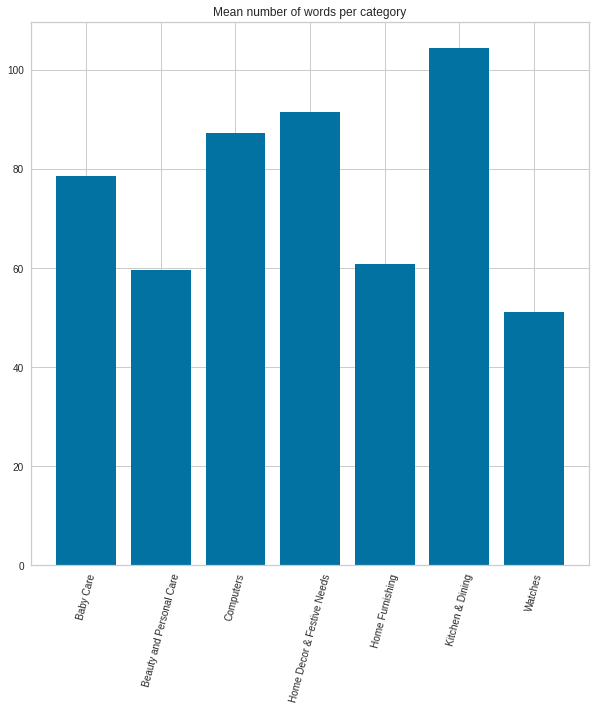

In [ ]:
k = data.loc[:,['product_category_tree','nWord']].groupby(by=['product_category_tree']).mean()
k = k.reset_index()
plt.figure(figsize=(10,10))
plt.title(label="Mean number of words per category")
plt.xticks(rotation='75')
plt.bar(k['product_category_tree'], k['nWord'])

Même comportement en moyenne

On peut découper les catégories comme tel:

1.   <60 mots en moyenne:
*   Beauty and Personnal Care
*   Home furnishing
*   Watches


2.   ~=80et+

*   Baby Care
*   Computers
*   Home Decor & Festive Needs
*   Kitchen & Dining


---
### Conversion en minuscules
---


In [ ]:
data.loc[:,"description"] = data.loc[:,"description"].str.lower()

for i in range(0, 5):
  print(str(i)+": "+data.loc[i,'description'])

0: key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant curtain that softly filters light in your room so that y

---
### Tokenization
---

Les 10 premiers mots de la première phrase de description

In [ ]:
data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: nltk.word_tokenize(x))

data.loc[0,'description'][0:10]

['key',
 'features',
 'of',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain']

In [ ]:
len(data.loc[0,'description'])

247

<BarContainer object of 7 artists>

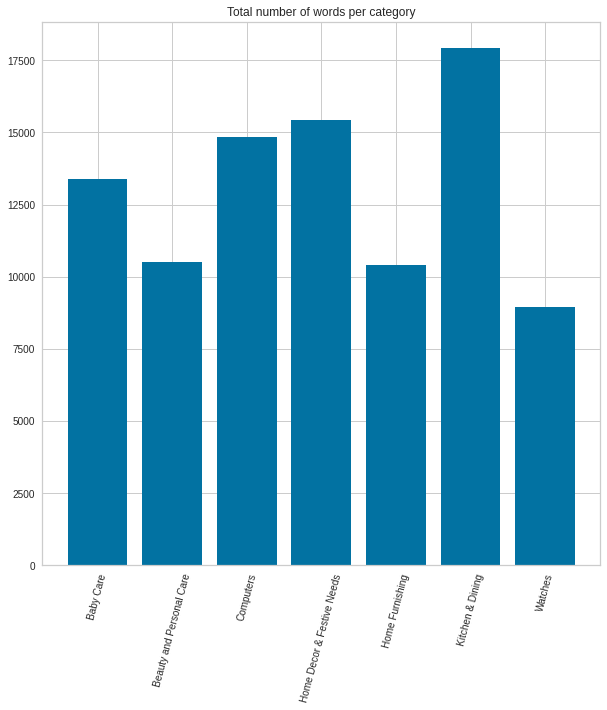

In [ ]:
data['nWord_bis'] = data.loc[:,'description'].apply(lambda x: len(x))
k = data.loc[:,['product_category_tree','nWord_bis']].groupby(by=['product_category_tree']).sum()
k = k.reset_index()
plt.figure(figsize=(10,10))
plt.title(label="Total number of words per category")
plt.xticks(rotation='75')
plt.bar(k['product_category_tree'], k['nWord_bis'])

<BarContainer object of 7 artists>

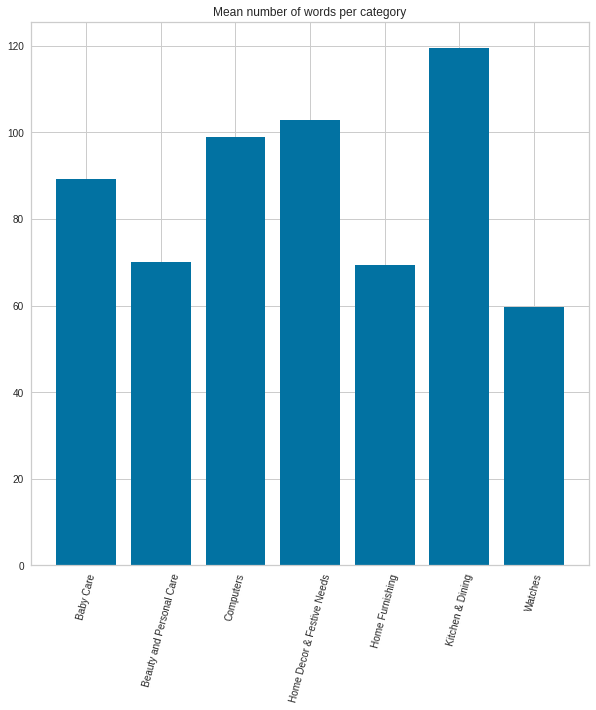

In [ ]:

k = data.loc[:,['product_category_tree','nWord_bis']].groupby(by=['product_category_tree']).mean()
k = k.reset_index()
plt.figure(figsize=(10,10))
plt.title(label="Mean number of words per category")
plt.xticks(rotation='75')
plt.bar(k['product_category_tree'], k['nWord_bis'])

Après tokenization les comportements sont conservés comme on peut l'observer sur les graphes ci dessus

---
### StopWords
---

In [ ]:
data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: [w for w in x if not w in nltk.corpus.stopwords.words('english')])

data.loc[0,'description'][0:10]

['key',
 'features',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral']

"of" a disparu

---
### Lemmatization
---

In [ ]:
lemmatizer = nltk.WordNetLemmatizer()

data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: [lemmatizer.lemmatize(n) for n in x])

data.loc[0,'description'][0:10]

['key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral']

"features" est devenu "feature"

<BarContainer object of 7 artists>

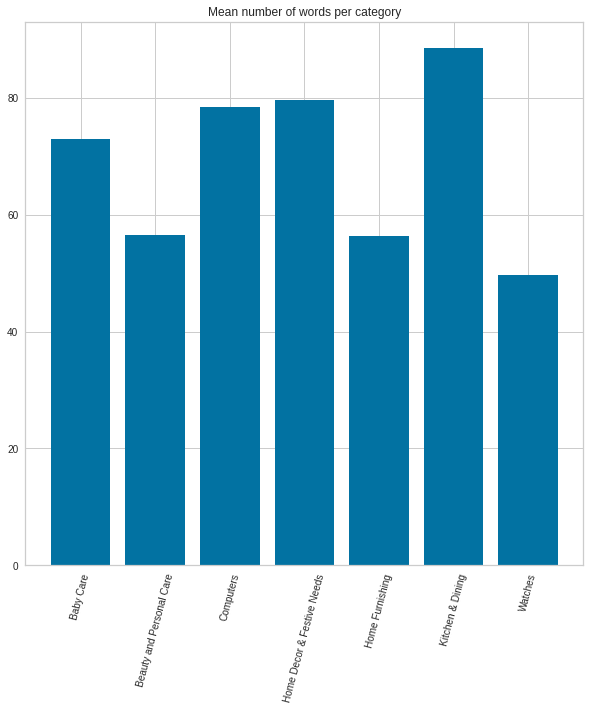

In [ ]:
data['nWord_ter'] = data.loc[:,'description'].apply(lambda x: len(x))
k = data.loc[:,['product_category_tree','nWord_ter']].groupby(by=['product_category_tree']).mean()
k = k.reset_index()
plt.figure(figsize=(10,10))
plt.title(label="Mean number of words per category")
plt.xticks(rotation='75')
plt.bar(k['product_category_tree'], k['nWord_ter'])

<BarContainer object of 7 artists>

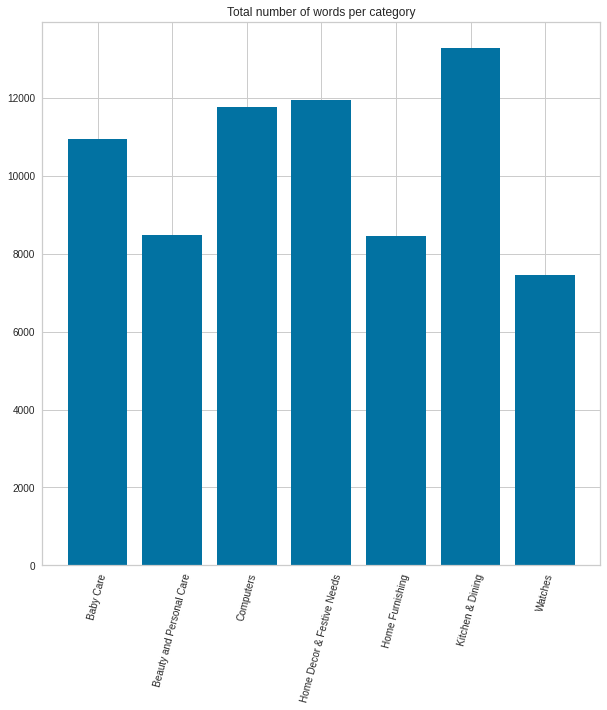

In [ ]:
k = data.loc[:,['product_category_tree','nWord_ter']].groupby(by=['product_category_tree']).sum()
k = k.reset_index()
plt.figure(figsize=(10,10))
plt.title(label="Total number of words per category")
plt.xticks(rotation='75')
plt.bar(k['product_category_tree'], k['nWord_ter'])

In [ ]:
" ".join(data.loc[0,'description'][0:10])

'key feature elegance polyester multicolor abstract eyelet door curtain floral'

Le comportement est toujours le même

---
#### CountVectorizer
---

In [ ]:
def join_it(x):
  return(" ".join(x))

data["feature_desc"] = data.loc[:,'description'].apply(lambda x: join_it(x))
data["feature_desc"]

0       key feature elegance polyester multicolor abst...
1       specification sathiyas cotton bath towel ( 3 b...
2       key feature eurospa cotton terry face towel se...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker ( pack ...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker rs...
1049    buy uberlyfe large vinyl sticker rs.595 online...
Name: feature_desc, Length: 1050, dtype: object

In [ ]:
label = data.loc[:,"product_category_tree"].unique() #on enregistre les noms de category uniques

In [ ]:
data.loc[0, "feature_desc"]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain , elegance polyester multicolor abstract eyelet door curtain ( 213 cm height , pack 2 ) price : r . 899 curtain enhances look interiors.this curtain made 100 % high quality polyester fabric.it feature eyelet style stitch metal ring.it make room environment romantic loving.this curtain ant- wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal design . surreal attention sure steal heart . contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening , create special moment joyous beauty given soothing print . bring home elegant curtain softly filter light room get right amount sunlight. , specification elegance polyester multicolor abstract eyelet door curtain ( 213 cm height , pack 2 ) general brand elegance designed door type eyelet model name abstract polyester door curtain set 2 

On retire:


1.   Les mots de moins de 3 lettres
2.   Les ponctuations
3.   Les chiffres


In [ ]:
def clean_sentence(s):
  k  = ' '.join([w for w in s.split() if len(w)>2])
  k = ''.join(' ' if w in string.punctuation else w for w in k)
  k = ''.join('' if w in string.digits else w for w in k)
  return(k)

data.loc[:, "feature_desc"] = data.loc[:, "feature_desc"].apply(lambda x : clean_sentence(x))
data.loc[0, "feature_desc"]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain  height pack price  curtain enhances look interiors this curtain made  high quality polyester fabric it feature eyelet style stitch metal ring it make room environment romantic loving this curtain ant  wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight  specification elegance polyester multicolor abstract eyelet door curtain  height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model duster color multicolor dimension length  box numb

On applique le CountVecotirzer

In [ ]:
#CountVectorizer(preprocessor=None, tokenizer=None, lowercase=False)
vectorizer = CountVectorizer(max_df=0.8, min_df=10, ngram_range=(2,2))
k = vectorizer.fit_transform(data.loc[:,"feature_desc"])
k

<1050x489 sparse matrix of type '<class 'numpy.int64'>'
	with 15472 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.get_feature_names_out()

array(['abstract double', 'abstract single', 'actual product',
       'adapter designed', 'adapter power', 'add kitchen',
       'additional detail', 'additional feature', 'adorable fantastic',
       'affordable mug', 'age group', 'also pass', 'also perfect',
       'analog watch', 'apply scratch', 'around enjoyment',
       'assured quality', 'attractive graphic',
       'authentication certification', 'baby boy', 'baby girl',
       'back case', 'bath towel', 'battery flipkart',
       'beautifully designed', 'best price', 'best quality',
       'black strap', 'body design', 'body feature', 'box number',
       'box sale', 'boy baby', 'boy buy', 'boy girl', 'brand color',
       'brand print', 'brass case', 'break mug', 'bring laugh',
       'bring smile', 'broadcast special', 'buckle clasp', 'buy maximum',
       'buy prithish', 'buy sonata', 'capacity material', 'care gentle',
       'care machine', 'care wash', 'cash delivery', 'casual get',
       'casual ideal', 'catchy design'

In [ ]:
print(k.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
l = np.where(k.toarray()[0,:] == 1)
vectorizer.get_feature_names_out()[l]

array(['body design', 'box number', 'color multicolor', 'content sale',
       'design material', 'dimension length', 'eyelet model',
       'general brand', 'high quality', 'key feature', 'made high',
       'material polyester', 'model name', 'multicolor dimension',
       'number content', 'pack general', 'pack price', 'pack sale',
       'package pack', 'type eyelet'], dtype=object)

In [ ]:
data.loc[0,'feature_desc']

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain  height pack price  curtain enhances look interiors this curtain made  high quality polyester fabric it feature eyelet style stitch metal ring it make room environment romantic loving this curtain ant  wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight  specification elegance polyester multicolor abstract eyelet door curtain  height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model duster color multicolor dimension length  box numb

On retrouve bien les mots communs

##### LDA

In [ ]:
vectorizer = CountVectorizer()
k = vectorizer.fit_transform(data.loc[:,"feature_desc"])

n_topics = len(label)

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=5,
        learning_method='online',
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(k)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=7, random_state=0)

In [ ]:
def display_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))

n_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), n_words)


Topic 0:
usb led fan light portable port flexible mobile keyboard phone
Topic 1:
adapter warranty laptop charger replacement vaio vgn power smartpro cre
Topic 2:
mug ceramic coffee perfect gift design one material give price
Topic 3:
bowl singing oil skin jewellery play reiki cleaning crystal soap
Topic 4:
hair wall sticker bottle applied pot decal surface trait surgical
Topic 5:
laptop color pack skin feature specification type general box package
Topic 6:
product free delivery buy shipping genuine cash day replacement guarantee


Les groupes ne sont pas de grandes qualités mais les notions de catégories sont distinguables ()

In [ ]:
data.product_category_tree.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)


---
### TF-IDF
---





In [ ]:
tfidf = TfidfVectorizer(max_df=0.8, min_df=10, ngram_range=(2,2))
res = tfidf.fit_transform(data.loc[:,"feature_desc"])
res

<1050x489 sparse matrix of type '<class 'numpy.float64'>'
	with 15472 stored elements in Compressed Sparse Row format>

In [ ]:
res.shape

(1050, 489)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


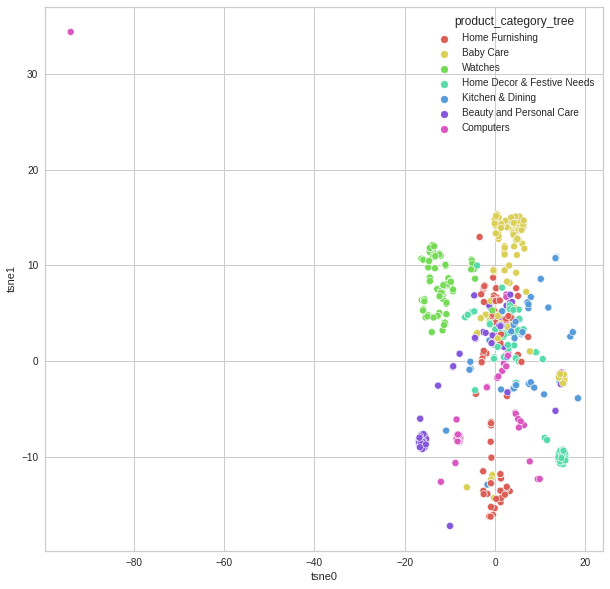

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(res)
df_tsne = pd.DataFrame(data=tsne_results[:,0], columns=["tsne0"])
df_tsne["tsne1"] = tsne_results[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne0", y="tsne1",
    data=df_tsne,
    palette=sns.color_palette("hls", len(label)),
    hue=data.loc[:,"product_category_tree"]
)

Certaines catégories sont observables et distinguables, notamment watches, home decor, et baby care.
Le reste est plus compliqué

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


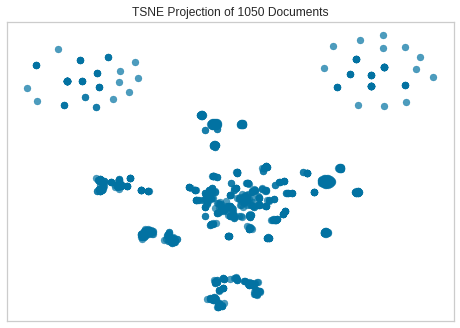

In [ ]:
tsne = TSNEVisualizer()
tsne.fit(res)
tsne.poof()

---
### PCA
---

In [ ]:
n = 100
pca = PCA(n_components=0.90)
pca_t = pca.fit_transform(res.toarray())
pca_t

array([[-0.33892789,  0.0599805 , -0.08889527, ...,  0.03310629,
         0.02257674,  0.05915623],
       [-0.31177333,  0.04308486, -0.08349072, ..., -0.04788165,
        -0.03565594, -0.03604806],
       [-0.35858454,  0.06487809, -0.08743477, ...,  0.01932838,
         0.01130723,  0.11601348],
       ...,
       [ 0.5553829 ,  0.51301153,  0.01155807, ...,  0.0066888 ,
         0.00646514, -0.00554721],
       [ 0.5553829 ,  0.51301153,  0.01155807, ...,  0.0066888 ,
         0.00646514, -0.00554721],
       [ 0.5553829 ,  0.51301153,  0.01155807, ...,  0.0066888 ,
         0.00646514, -0.00554721]])

In [ ]:
pca.n_components_

88

In [ ]:
pca.explained_variance_

array([0.10122298, 0.0748542 , 0.05333565, 0.03323018, 0.02644071,
       0.02133007, 0.01783614, 0.01608543, 0.01451435, 0.01437206,
       0.01309619, 0.01285595, 0.01186705, 0.01164107, 0.01121485,
       0.01097841, 0.01077294, 0.01063851, 0.01029125, 0.01013989,
       0.00973726, 0.00935768, 0.00903585, 0.00871739, 0.00858826,
       0.00810239, 0.00798663, 0.00773914, 0.00755803, 0.0073562 ,
       0.00730993, 0.00688134, 0.00662752, 0.00657468, 0.0064024 ,
       0.00633201, 0.00616222, 0.00600368, 0.0058726 , 0.00581989,
       0.00569535, 0.00556914, 0.00533836, 0.00518658, 0.0049396 ,
       0.00479884, 0.00474553, 0.00461176, 0.00437826, 0.00436403,
       0.00424927, 0.00423386, 0.00400591, 0.0039352 , 0.00384277,
       0.00377246, 0.00375088, 0.00365963, 0.00361178, 0.00354764,
       0.00348553, 0.00326859, 0.0031852 , 0.00309927, 0.00305193,
       0.00303686, 0.00290712, 0.00277772, 0.00274913, 0.00272432,
       0.00266082, 0.00258364, 0.00252431, 0.00245213, 0.00239

In [ ]:
pca.explained_variance_ratio_

array([0.1151191 , 0.08513035, 0.06065769, 0.03779209, 0.03007055,
       0.02425831, 0.02028473, 0.01829367, 0.01650691, 0.01634509,
       0.01489406, 0.01462084, 0.01349618, 0.01323919, 0.01275445,
       0.01248555, 0.01225188, 0.01209899, 0.01170405, 0.01153191,
       0.01107401, 0.01064232, 0.01027631, 0.00991414, 0.00976728,
       0.00921471, 0.00908305, 0.00880159, 0.00859561, 0.00836607,
       0.00831345, 0.00782602, 0.00753736, 0.00747727, 0.00728134,
       0.00720128, 0.00700818, 0.00682788, 0.0066788 , 0.00661886,
       0.00647722, 0.00633368, 0.00607122, 0.00589861, 0.00561772,
       0.00545763, 0.005397  , 0.00524488, 0.00497932, 0.00496313,
       0.00483262, 0.00481509, 0.00455585, 0.00447543, 0.00437031,
       0.00429036, 0.0042658 , 0.00416204, 0.00410761, 0.00403467,
       0.00396403, 0.00371731, 0.00362247, 0.00352474, 0.0034709 ,
       0.00345377, 0.00330622, 0.00315905, 0.00312653, 0.00309832,
       0.00302611, 0.00293833, 0.00287086, 0.00278876, 0.00271

In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.1151191 , 0.20024945, 0.26090714, 0.29869923, 0.32876978,
       0.35302809, 0.37331281, 0.39160649, 0.4081134 , 0.42445848,
       0.43935255, 0.45397339, 0.46746957, 0.48070876, 0.49346321,
       0.50594876, 0.51820063, 0.53029962, 0.54200368, 0.55353559,
       0.5646096 , 0.57525193, 0.58552824, 0.59544237, 0.60520965,
       0.61442436, 0.62350741, 0.632309  , 0.6409046 , 0.64927068,
       0.65758413, 0.66541015, 0.67294751, 0.68042478, 0.68770611,
       0.6949074 , 0.70191558, 0.70874346, 0.71542226, 0.72204112,
       0.72851834, 0.73485202, 0.74092325, 0.74682185, 0.75243958,
       0.75789721, 0.76329421, 0.76853909, 0.77351841, 0.77848154,
       0.78331416, 0.78812925, 0.7926851 , 0.79716054, 0.80153085,
       0.8058212 , 0.81008701, 0.81424904, 0.81835665, 0.82239132,
       0.82635535, 0.83007266, 0.83369513, 0.83721988, 0.84069078,
       0.84414455, 0.84745077, 0.85060983, 0.85373636, 0.85683468,
       0.85986079, 0.86279912, 0.86566998, 0.86845874, 0.87117

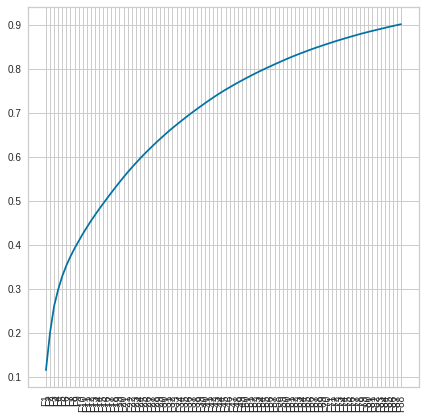

In [ ]:
list_f = []
n =pca.n_components_
for i in range(0, n):
    list_f.append("F"+str(i+1))


plt.figure(figsize=(7,7))
plt.xticks(rotation='90')
plt.plot(list_f, pca.explained_variance_ratio_.cumsum()[0:n])

 okay pas ouf le pca

### Truncated SVD

In [ ]:
# svd = TruncatedSVD(n_components = res.shape[1]-1, random_state=0)
n=88
svd = TruncatedSVD(n_components = n, random_state=0)
res_svd = svd.fit_transform(res)

In [ ]:
print(svd.explained_variance_ratio_)

[0.0993001  0.08553914 0.06080474 0.03046736 0.03751746 0.02684063
 0.02276226 0.01981413 0.01711799 0.01647778 0.01493473 0.01472864
 0.01359258 0.01323997 0.01322182 0.01262663 0.01228486 0.01220434
 0.01173217 0.01157594 0.01141731 0.01072522 0.01055034 0.00997878
 0.00991287 0.00921629 0.00915473 0.00879922 0.00861013 0.00850844
 0.00831347 0.00814357 0.0078158  0.00750129 0.00741484 0.00722794
 0.00719113 0.00683663 0.00680833 0.00663067 0.00652069 0.0064105
 0.00612337 0.0060665  0.00582368 0.00561054 0.00543078 0.00539666
 0.00524482 0.00497902 0.00495913 0.00483087 0.00481246 0.00455579
 0.00446807 0.00437027 0.00428896 0.00424252 0.0041618  0.00410678
 0.00403342 0.00396386 0.00371692 0.00360249 0.00350154 0.00345561
 0.00342487 0.00330483 0.00313712 0.00312365 0.00309543 0.00302316
 0.00293574 0.00284851 0.00277091 0.00271329 0.00266939 0.00261955
 0.00252136 0.00243301 0.00241138 0.0022399  0.00223082 0.00221037
 0.00218706 0.00210958 0.00207633 0.00202213]


In [ ]:
print(svd.explained_variance_ratio_.cumsum())

[0.0993001  0.18483925 0.24564399 0.27611135 0.31362881 0.34046945
 0.3632317  0.38304583 0.40016382 0.4166416  0.43157633 0.44630497
 0.45989755 0.47313752 0.48635933 0.49898596 0.51127082 0.52347516
 0.53520733 0.54678327 0.55820058 0.56892579 0.57947613 0.58945491
 0.59936778 0.60858407 0.6177388  0.62653801 0.63514814 0.64365658
 0.65197004 0.66011362 0.66792941 0.67543071 0.68284555 0.69007349
 0.69726462 0.70410125 0.71090958 0.71754026 0.72406095 0.73047145
 0.73659483 0.74266132 0.748485   0.75409554 0.75952632 0.76492298
 0.7701678  0.77514682 0.78010595 0.78493682 0.78974928 0.79430507
 0.79877314 0.80314341 0.80743237 0.81167489 0.81583668 0.81994346
 0.82397688 0.82794074 0.83165766 0.83526014 0.83876169 0.84221729
 0.84564217 0.84894699 0.85208411 0.85520776 0.85830319 0.86132634
 0.86426209 0.8671106  0.86988151 0.8725948  0.87526418 0.87788374
 0.8804051  0.88283811 0.8852495  0.88748939 0.88972021 0.89193058
 0.89411764 0.89622722 0.89830355 0.90032568]


In [ ]:
svd.explained_variance_ratio_.cumsum()

array([0.0993001 , 0.18483925, 0.24564399, 0.27611135, 0.31362881,
       0.34046945, 0.3632317 , 0.38304583, 0.40016382, 0.4166416 ,
       0.43157633, 0.44630497, 0.45989755, 0.47313752, 0.48635933,
       0.49898596, 0.51127082, 0.52347516, 0.53520733, 0.54678327,
       0.55820058, 0.56892579, 0.57947613, 0.58945491, 0.59936778,
       0.60858407, 0.6177388 , 0.62653801, 0.63514814, 0.64365658,
       0.65197004, 0.66011362, 0.66792941, 0.67543071, 0.68284555,
       0.69007349, 0.69726462, 0.70410125, 0.71090958, 0.71754026,
       0.72406095, 0.73047145, 0.73659483, 0.74266132, 0.748485  ,
       0.75409554, 0.75952632, 0.76492298, 0.7701678 , 0.77514682,
       0.78010595, 0.78493682, 0.78974928, 0.79430507, 0.79877314,
       0.80314341, 0.80743237, 0.81167489, 0.81583668, 0.81994346,
       0.82397688, 0.82794074, 0.83165766, 0.83526014, 0.83876169,
       0.84221729, 0.84564217, 0.84894699, 0.85208411, 0.85520776,
       0.85830319, 0.86132634, 0.86426209, 0.8671106 , 0.86988

In [ ]:
print(svd.singular_values_)

[13.58162289  8.8978278   7.53184774  6.09401445  5.89926625  5.0705144
  4.62389201  4.2834146   3.98525739  3.89868084  3.71676416  3.69000009
  3.56702426  3.50646206  3.49345403  3.41477799  3.36860536  3.35662488
  3.29531258  3.27321391  3.25138245  3.15255342  3.12325661  3.03932145
  3.023845    2.92113087  2.90967081  2.85465972  2.83345725  2.80825118
  2.76914134  2.75552316  2.68545265  2.63091409  2.61762281  2.5835761
  2.57595486  2.51458292  2.50745387  2.47343271  2.45585441  2.434673
  2.38905369  2.36588203  2.32224355  2.27525009  2.23945463  2.23110599
  2.19947598  2.14302452  2.13887004  2.11094336  2.10695907  2.04991314
  2.03026087  2.00773734  1.98898448  1.97876336  1.95926751  1.9462851
  1.92882212  1.91208556  1.85154868  1.82294206  1.7973018   1.7851989
  1.77807885  1.7457677   1.7011665   1.69720781  1.68952677  1.66984737
  1.64516013  1.61990783  1.59844086  1.58104363  1.56861652  1.55425449
  1.52477048  1.4973425   1.49109244  1.43626271  1.43254

Text(0.5, 0, '')

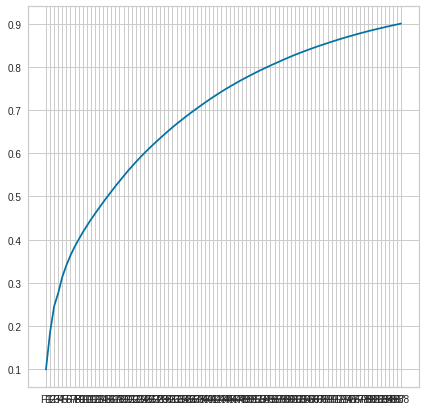

In [ ]:
list_f = []

for i in range(0, n):
    list_f.append("F"+str(i+1))


plt.figure(figsize=(7,7))
plt.plot(list_f, svd.explained_variance_ratio_.cumsum()[0:n])
plt.xlabel(xlabel = None)


---
### Sparce PCA
---

In [ ]:
# spca = SparsePCA(n_components=res.shape[1]-1, random_state=0) #more than 15mn on stop
spca = SparsePCA(n_components= 20, random_state=0, verbose=1)
res_spca = spca.fit_transform(res.toarray())

[dict_learning] ........1 unused atoms resampled.
.1 unused atoms resampled.
.1 unused atoms resampled.
.1 unused atoms resampled.
.......................................


In [ ]:
res_spca.cumsum()[-1]

1.8893098890915283e-12

In [ ]:
spca = SparsePCA(n_components= 50, random_state=0, verbose=1)
res_spca = spca.fit_transform(res.toarray())

[dict_learning] ..3 unused atoms resampled.
.5 unused atoms resampled.
.5 unused atoms resampled.
.7 unused atoms resampled.
.3 unused atoms resampled.
.3 unused atoms resampled.
.2 unused atoms resampled.
.2 unused atoms resampled.
.2 unused atoms resampled.
...................................


In [ ]:
res_spca.cumsum()[-1]

1.0278704970501096e-12

In [ ]:
spca = SparsePCA(n_components= 150, random_state=0)
res_spca = spca.fit_transform(res.toarray())

In [ ]:
res_spca.cumsum()[-1]

-7.413191588367951e-12

Beaucoup de temps pour des résultats au mieux équivalents

In [ ]:
# list_f = []

# for i in range(0, n):
#     list_f.append("F"+str(i+1))


# plt.figure(figsize=(7,7))
# plt.xticks(rotation='90')
#plt.plot(list_f, spca.explained_variance_ratio_.cumsum()[0:n])

On va conserver le TruncatedSVD

---
### Clustering avec Kmeans
---


#### Réflexe

elbow method par réflexe, mais on va chercher à voir 7 catégories

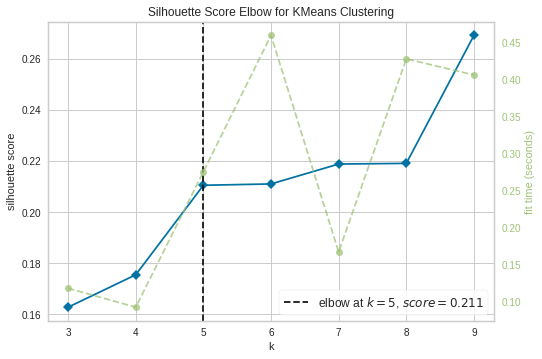

In [ ]:
model = KMeans(init="k-means++", random_state=0)
visualizer = KElbowVisualizer(model, k=(3,10), metric="silhouette")

visualizer.fit(res_svd)
visualizer.show()

For n_clusters = 3 The average silhouette_score is : 0.16279393333542694
For n_clusters = 4 The average silhouette_score is : 0.19681794885963774
For n_clusters = 5 The average silhouette_score is : 0.21047413729406297
For n_clusters = 6 The average silhouette_score is : 0.21099709517504683
For n_clusters = 7 The average silhouette_score is : 0.21544455571103596
For n_clusters = 8 The average silhouette_score is : 0.23409042628188798
For n_clusters = 9 The average silhouette_score is : 0.2431691580335304


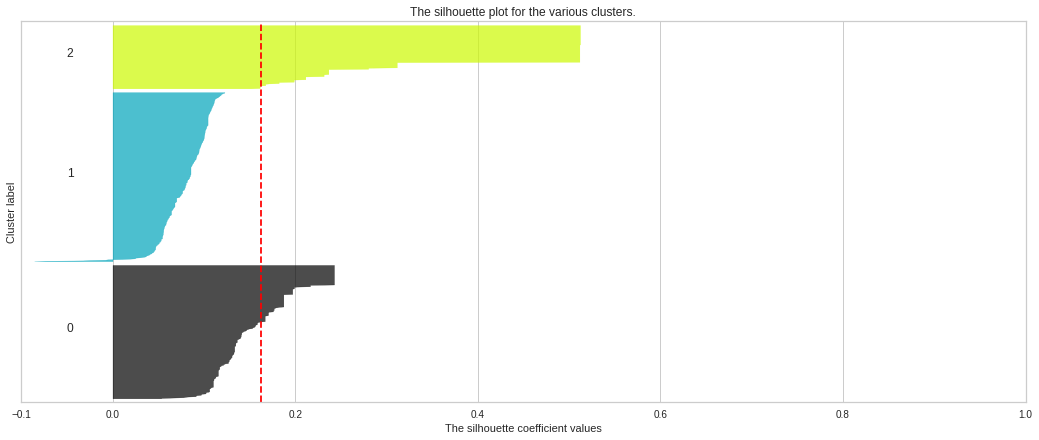

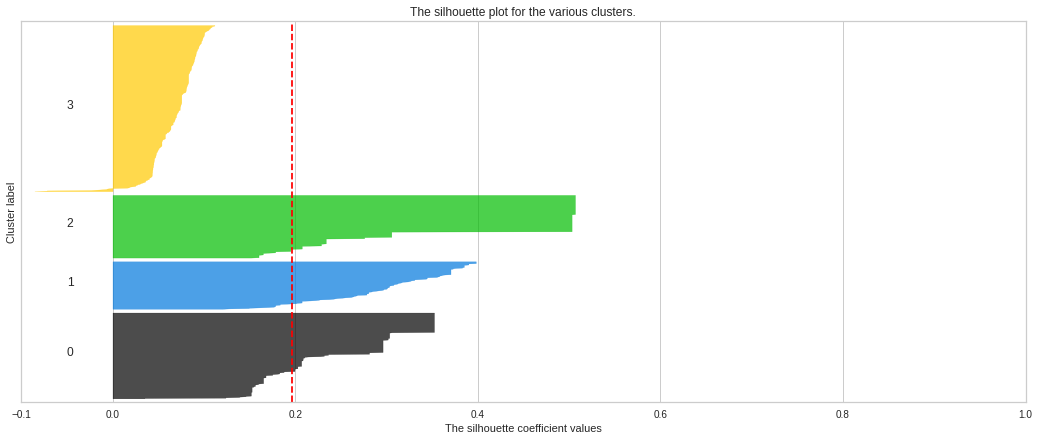

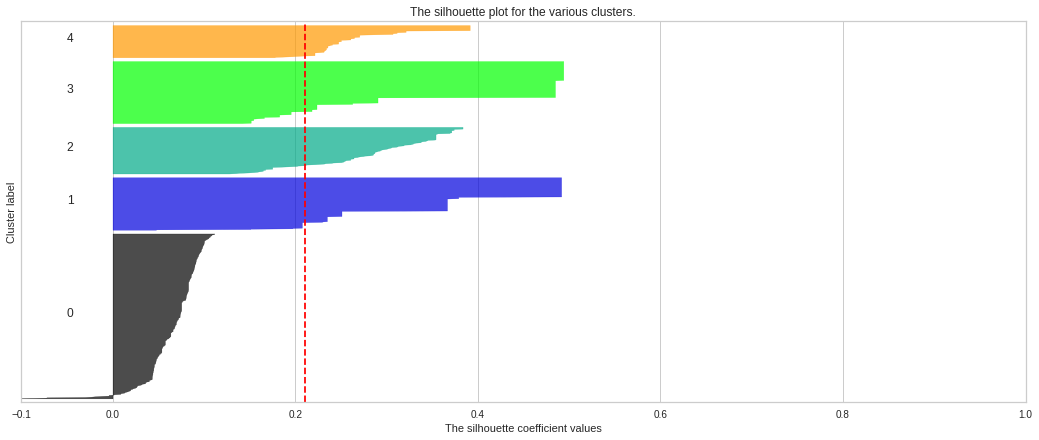

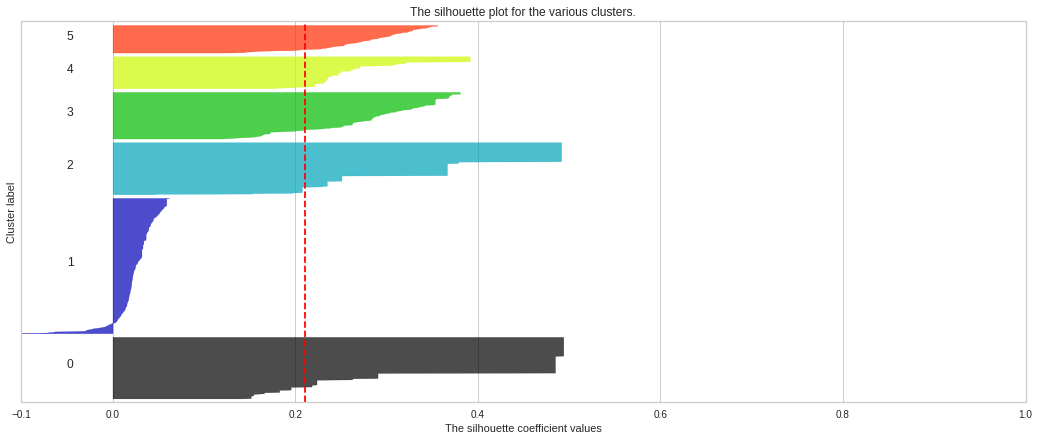

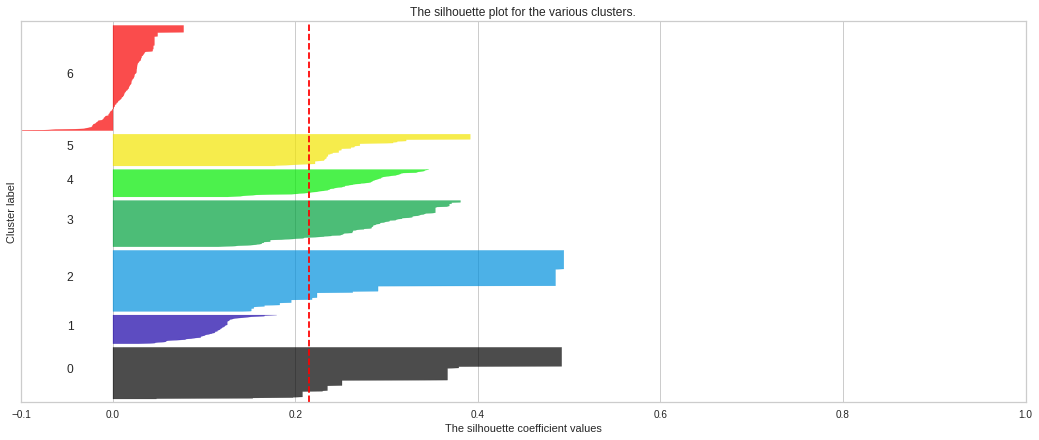

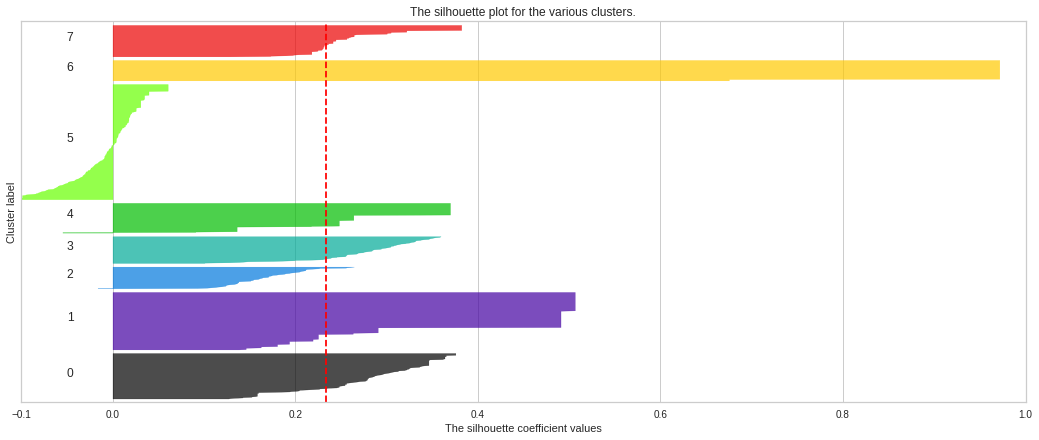

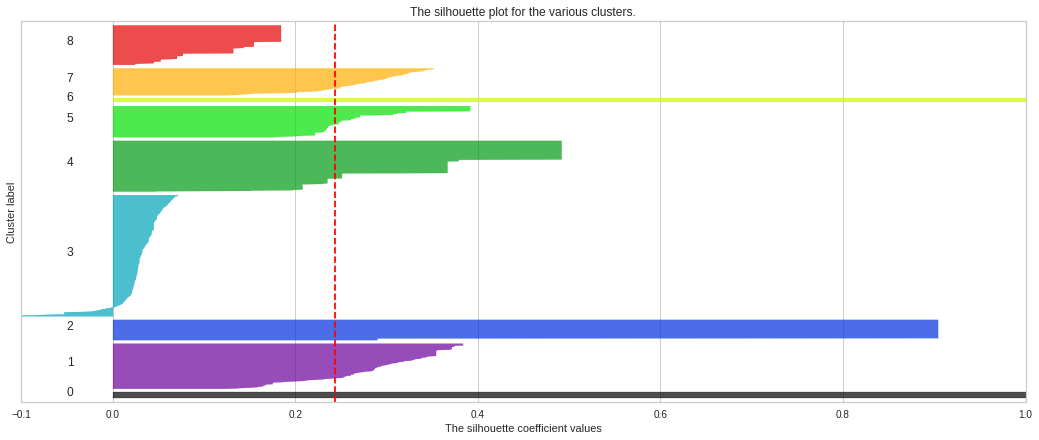

In [ ]:
range_n_clusters = range(3, 10)

for n_clusters in range_n_clusters:
#     fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(res_svd) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(res_svd)

    silhouette_avg = silhouette_score(res_svd, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(res_svd, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [ ]:
model = KMeans(n_clusters=7, init="k-means++", random_state=0)
kmeans = model.fit(res_svd)

Application Kmeans

In [ ]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[6 6 6 ... 1 1 1]
[[ 4.57192315e-01 -2.89763131e-01 -2.70705251e-01  6.09311897e-03
   4.47123102e-01 -4.41513492e-03 -6.67192450e-04 -1.28421408e-01
   2.58832609e-02 -5.18861267e-03 -1.04790890e-03  8.76393626e-03
   4.55220643e-04 -6.50750136e-03  5.27251769e-03  4.58851992e-03
  -5.26310261e-03  2.90062804e-03 -1.56826742e-03  2.73200158e-04
   5.39341602e-03  2.62037767e-02  9.05699759e-03 -5.45548597e-03
  -3.51944342e-03  2.99176516e-04 -1.24502209e-03 -3.48165528e-03
  -5.34393659e-03  2.43804500e-03 -2.24527984e-03 -1.91673112e-03
  -8.74259819e-04 -3.34084091e-04 -1.42659839e-03  6.56524776e-04
   9.06658176e-04  4.35722721e-03  2.89285059e-03  2.69137882e-03
  -2.03373205e-03 -2.09186730e-03 -8.35388995e-04 -4.64966265e-03
   1.88473964e-04 -2.66975935e-03 -3.29532262e-03 -1.88085781e-03
   2.59229151e-04 -1.52485660e-03  9.67790332e-03  2.38465331e-03
   1.07208999e-03  3.34640505e-05 -2.90799797e-04  3.30777020e-04
   7.79078623e-03  1.01739487e-03  1.28653065e-05  1.76880

#### TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=70, n_iter=300)
tsne_results = tsne.fit_transform(res_svd)

df_tsne = pd.DataFrame(data=tsne_results[:,0], columns=["tsne0"])
df_tsne["tsne1"] = tsne_results[:,1]
df_tsne["category"] = data.loc[:, "product_category_tree"]
df_tsne

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,tsne0,tsne1,category
0,-3.311196,2.369762,Home Furnishing
1,-6.535666,2.288952,Baby Care
2,0.353539,1.061990,Baby Care
3,-0.292316,-0.896869,Home Furnishing
4,-0.265763,-0.885251,Home Furnishing
...,...,...,...
1045,4.775633,6.861450,Baby Care
1046,1.481882,-0.440178,Baby Care
1047,1.432368,14.474854,Baby Care
1048,1.349863,13.990013,Baby Care


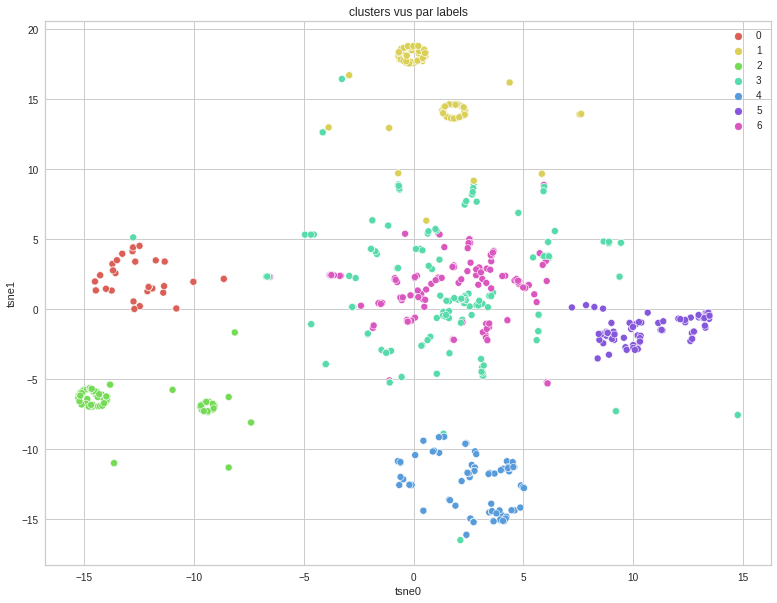

In [ ]:
plt.figure(figsize=(13,10))
plt.title("clusters vus par labels")
sns.scatterplot(
    x="tsne0", y="tsne1",
    data=df_tsne,
    palette=sns.color_palette("hls", 7),
    hue=kmeans.labels_,
    legend="auto"
)
sns.scatterplot()

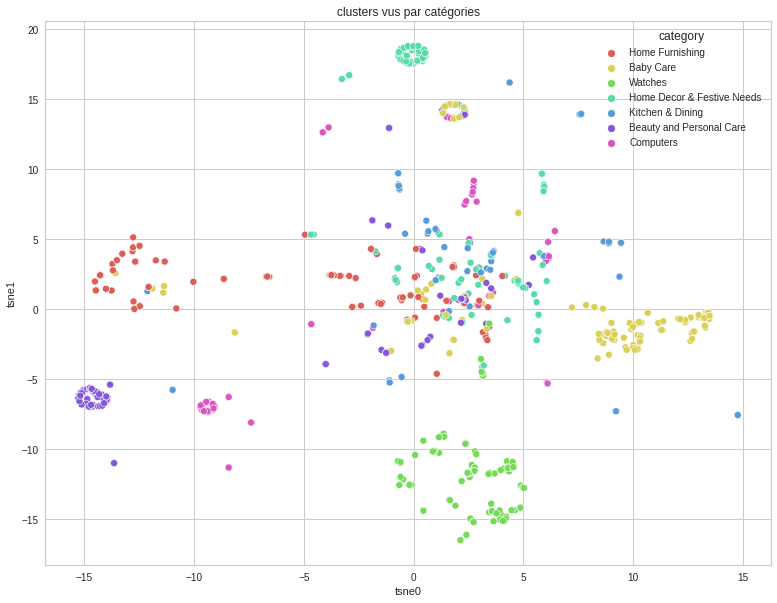

In [ ]:
plt.figure(figsize=(13,10))
plt.title("clusters vus par catégories")
sns.scatterplot(
    x="tsne0", y="tsne1",
    data=df_tsne,
    palette=sns.color_palette("hls", 7),
    hue="category",
    legend="auto"
)
sns.scatterplot()

De même certaines catégories sont assez distinguables mais pas toutes.


#### Distribution des clusters sur les catégories

In [ ]:
data["cluster_label"] = kmeans.labels_

In [ ]:
data.loc[:, "product_category_tree"].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Pour le cluster 0


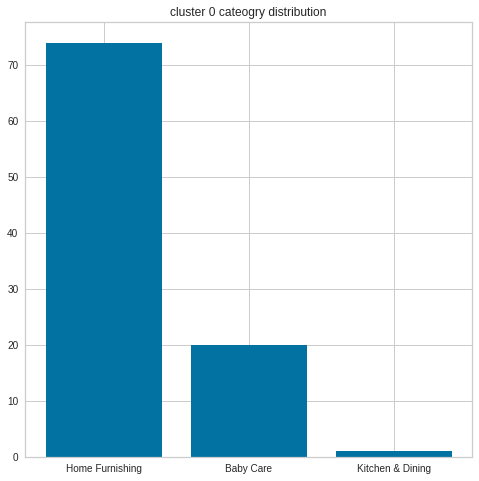

Pour le cluster 1


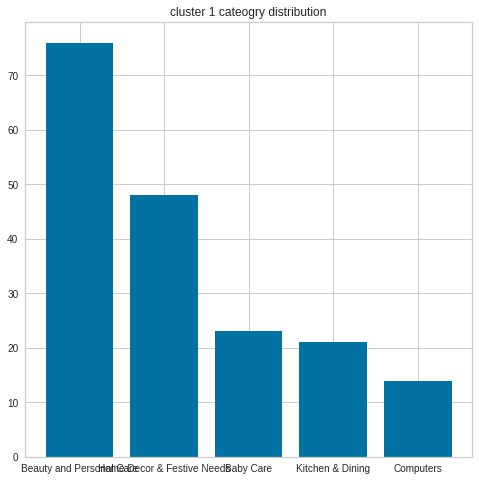

Pour le cluster 2


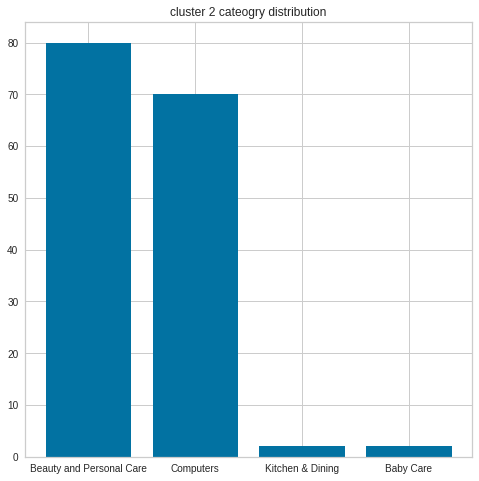

Pour le cluster 3


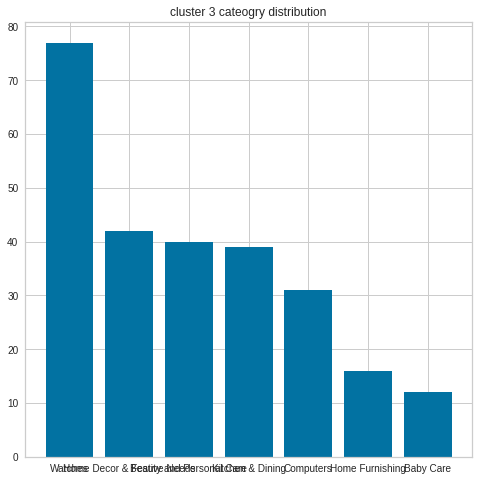

Pour le cluster 4


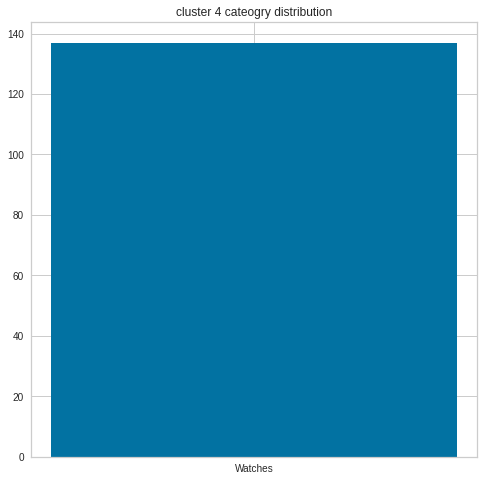

Pour le cluster 5


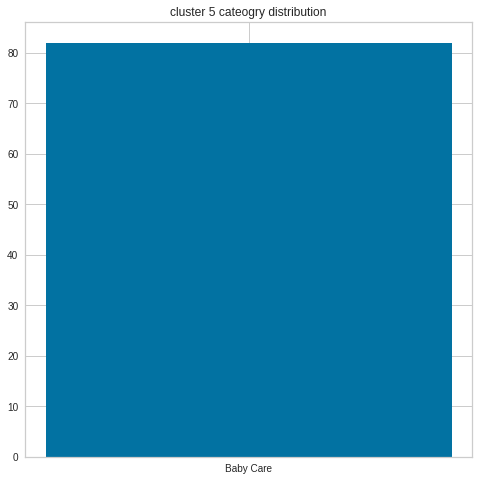

Pour le cluster 6


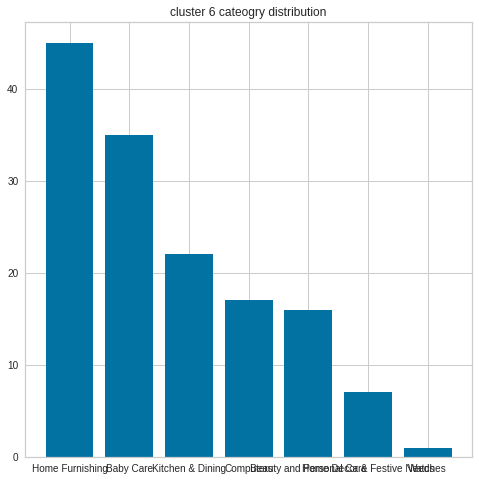

In [ ]:
# data.loc[:, "product_category_tree"].unique()
for i in range(0,7):
  print("Pour le cluster "+str(i))
  l_category = data.loc[data["cluster_label"]==i, "product_category_tree"].unique()
  plt.figure(figsize=(8,8))
  plt.bar(l_category,
          data.loc[data["cluster_label"]==i, "product_category_tree"].value_counts())
  plt.title(label="cluster "+str(i)+" cateogry distribution")
  plt.show()



Comme expliqué plus tôt certaines ressortent beaucoup plus, là ou d'autres vont être trop hétérogènes en termes de catégories.

In [ ]:
lcat = data.loc[:,"product_category_tree"].unique()
lcat

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

####Score ARI

In [ ]:
def clusterit(x, l):
  return(np.where(l==x)[0][0])

data.loc[:,"cluster_category"] = data.loc[:,"product_category_tree"].apply(lambda x: clusterit(x, lcat))


In [ ]:
data.loc[:, ["cluster_label", "cluster_category", "product_category_tree"]]

,cluster_label,cluster_category,product_category_tree
0,6,0,Home Furnishing
1,6,1,Baby Care
2,6,1,Baby Care
3,6,0,Home Furnishing
4,6,0,Home Furnishing
...,...,...,...
1045,3,1,Baby Care
1046,3,1,Baby Care
1047,1,1,Baby Care
1048,1,1,Baby Care


In [ ]:
adjusted_rand_score(data.loc[:,"cluster_category"], data.loc[:,"cluster_label"])

0.2986582878158066

#### Mini Poubelle

In [ ]:
model_3 = KMeans(n_clusters=3, init="k-means++", random_state=0)
kmeans_3 = model_3.fit(res_svd)

In [ ]:
data["cluster_label_3"] = kmeans_3.labels_
for i in range(0,3):
  print("Pour le cluster "+str(i))
  l_category = data.loc[data["cluster_label_3"]==i, "product_category_tree"].unique()
  plt.figure(figsize=(8,8))
  plt.bar(l_category,
          data.loc[data["cluster_label_3"]==i, "product_category_tree"].value_counts())
  plt.title(label="cluster "+str(i)+" cateogry distribution")
  plt.show()

---
## Universal Sentence Encoder
---

### Modele

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

In [ ]:
USE = embed(data.loc[:,"feature_desc"])
USE

---
### PCA
---

In [ ]:
pca = PCA(n_components=0.99)
pca_USE = pca.fit_transform(USE)
pca.n_components_

In [ ]:
pca = PCA(n_components=0.90)
pca_USE = pca.fit_transform(USE)
pca.n_components_

In [ ]:
pca.explained_variance_ratio_.cumsum()

---
### Clustering avec Kmeans
---

In [ ]:
model_USE = KMeans(n_clusters=7, init="k-means++", random_state=0)
kmeans_USE = model_USE.fit(pca_USE)

In [ ]:
data["cluster_label_USE"] = kmeans_USE.labels_

---
#### TSNE
---

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=70, n_iter=300)
tsne_results = tsne.fit_transform(pca_USE)

df_tsne = pd.DataFrame(data=tsne_results[:,0], columns=["tsne0"])
df_tsne["tsne1"] = tsne_results[:,1]
df_tsne["category"] = data.loc[:, "product_category_tree"]
df_tsne

In [ ]:
plt.figure(figsize=(13,10))
plt.title("clusters vus par labels")
sns.scatterplot(
    x="tsne0", y="tsne1",
    data=df_tsne,
    palette=sns.color_palette("hls", 7),
    hue=kmeans.labels_,
    legend="auto"
)
sns.scatterplot()

In [ ]:
plt.figure(figsize=(13,10))
plt.title("clusters vus par catégories")
sns.scatterplot(
    x="tsne0", y="tsne1",
    data=df_tsne,
    palette=sns.color_palette("hls", 7),
    hue="category",
    legend="auto"
)
sns.scatterplot()

In [ ]:
# modele 4
# tsne = TSNE(n_components=2, verbose=0, perplexity=70, n_iter=300)
# tsne_results = tsne.fit_transform(pca_USE)

# df_tsne = pd.DataFrame(data=tsne_results[:,0], columns=["tsne0"])
# df_tsne["tsne1"] = tsne_results[:,1]

# plt.figure(figsize=(13,10))
# sns.scatterplot(
#     x="tsne0", y="tsne1",
#     data=df_tsne,
#     palette=sns.color_palette("hls", 7),
#     hue=kmeans_USE.labels_
# )

---
#### Distribution des clusters sur les catégories
---

In [ ]:
for i in range(0,7):
  print("Pour le cluster "+str(i))
  l_category = data.loc[data["cluster_label_USE"]==i, "product_category_tree"].unique()
  plt.figure(figsize=(8,8))
  plt.xticks(rotation=90)
  plt.bar(l_category,
          data.loc[data["cluster_label_USE"]==i, "product_category_tree"].value_counts())
  plt.title(label="cluster "+str(i)+" cateogry distribution")
  plt.show()

Même conclusions, certaines categories ressortent très bien en monopolisant un cluster, d'autres sont plus homnogènes.

#### Score ARI

In [1]:
adjusted_rand_score(data.loc[:,"cluster_category"], data.loc[:,"cluster_label_USE"])

NameError: name 'adjusted_rand_score' is not defined

In [ ]:
# adjusted_rand_score(data.loc[:,"cluster_category"], data.loc[:,"cluster_label_USE"]) score = 0.31556804577012343 pour le modele 4

---
# Conclusions
---

# Poubelle

In [ ]:
# POUBELLE
# def dummy(x):
#     return x

# cv = CountVectorizer(
#         tokenizer=dummy,
#         preprocessor=dummy,
#     )
# cv.fit(data.loc[0,"description"])
# cv.get_feature_names_out()



# def my_preprocessor(txt):
#   txt = str(txt).lower()
#   #txt = str.lower(txt)
#   #txt = nltk.word_tokenize(txt)
#   txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]
#   txt = [lemmatizer.lemmatize(n) for n in txt]
#   return([txt])
#   #print(txt)

# def my_tokenizer(txt):
#     return(nltk.word_tokenize(txt))

#my_preprocessor(original_data.loc[0,"description"])




# data_bis = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv', sep=',')
# vectorizer = CountVectorizer(tokenizer= my_tokenizer, preprocessor=my_preprocessor)
# #X = vectorizer.fit_transform(data_bis.loc[0:3,"description"].apply(lambda x: str.join(x)))
# #vectorizer.get_feature_names_out()





# data = original_data
# data = data.drop(columns=["brand"])
# data = data.dropna()

# data.loc[:,"description"] = data.loc[:,"description"].astype(str).str.lower()

# data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: nltk.word_tokenize(x))

# data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: [w for w in x if not w in nltk.corpus.stopwords.words('english')])

# lemmatizer = nltk.WordNetLemmatizer()

# data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: [lemmatizer.lemmatize(n) for n in x])

# data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: list(nltk.bigrams(x)))

# #vectorizer = CountVectorizer(lowercase=False, preprocessor=None, tokenizer=None)
# #vectorizer = CountVectorizer()
# #k = vectorizer.fit_transform(data.description)

# print(data.loc[0, "description"])




# data_bis = original_data

# data.loc[:,"description"] = data.loc[:,"description"].astype(str).str.lower()

# data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: nltk.word_tokenize(x))

# data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: [w for w in x if not w in nltk.corpus.stopwords.words('english')])

# lemmatizer = nltk.WordNetLemmatizer()

# data.loc[:,"description"] = data.loc[:,"description"].apply(lambda x: [lemmatizer.lemmatize(n) for n in x])

# #vectorizer = CountVectorizer(lowercase=False, preprocessor=None, tokenizer=None)
# vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
# k = vectorizer.fit_transform(data_bis.description)
# k








# def my_preprocessor(txt):
#   txt = str(txt).lower()
#   #txt = str.lower(txt)
#   txt = nltk.word_tokenize(txt)
#   txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]
#   txt = [lemmatizer.lemmatize(n) for n in txt]
#   return(txt)
#   #print(txt)

# def my_tokenizer(txt):
#     return(nltk.word_tokenize(txt))

# vectorizer = CountVectorizer(preprocessor=my_preprocessor, tokenizer=None, lowercase=False, )
# k = vectorizer.fit_transform(data_bis.description)